# Energy Evaluation

### Define Energy Intesities

In [2]:
TRACE_RETENTION_DAYS = 30 # 30 days

# energy intensity kWh/GB
ENERGY_INTENSITY_NETWORK_KWH_PER_GB = 0.001875
ENERGY_INTENSITY_STORAGE_KWH_PER_GB_YEAR = 0.0046
ENERGY_INTENSITY_STORAGE_KWH_PER_GB = (ENERGY_INTENSITY_STORAGE_KWH_PER_GB_YEAR / 365) * TRACE_RETENTION_DAYS


## Load pre-processed data
This data can be pre-processed with the help of kepler-evaluation.ipynb (CPU+RAM), network-evaluation.ipynb and storage-evaluation.ipynb. If you want to do new experiments, you have to create these files yourself in the meantioned jupyter notebooks.

In [3]:
import pandas as pd
import tabulate as tabulate
network_data = pd.read_csv("cadvisor_network_bytes_received_all_absolute_bytes.csv", index_col=0)
network_data_transmitted = pd.read_csv("cadvisor_network_bytes_transmitted_all_absolute_bytes.csv", index_col=0)
storage_data = pd.read_csv("cadvisor_storage_usage_writes_all_absolute_bytes.csv", index_col=0)
kepler_data_joules = pd.read_csv("pods_kepler_joules_all_absolute_joules.csv", index_col=0)
kepler_dram = pd.read_csv("pods_kepler_dram_joules_all_joules.csv", index_col=0)


In [4]:
print("Total measurement points: ",  network_data.size + network_data_transmitted.size + storage_data.size + kepler_data_joules.size + kepler_dram.size)


Total measurement points:  124509


## Network
Further process the network data to transform total bytes received to kWh using the energy intensity

In [5]:
# get the last value for each label based on the time_normalized_rounded as this is the total amount of data received
network_data_processed = network_data.groupby("label").last().reset_index()


# remove the column time_normalized_rounded as it is not needed anymore
network_data_processed = network_data_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
network_data_processed.columns = network_data_processed.columns.str.replace("_system-under-evaluation", "", regex=False)

network_data_processed = network_data_processed.set_index("label")

network_data_processed = network_data_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
    "Base Persistence",
    "Scrape 30s Persistence",
    "Scrape 5s Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Persistence Istio",
])

# drop indexes the experiments that are not needed e.g. Baseline, 0%, 5%, 10%, 50%, 1s, 30s
network_data_processed = network_data_processed.drop(index=[
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
])

# rename the columns to be more readable
network_data_processed = network_data_processed.rename(index={
    "Base Persistence": "Baseline",
    "Scrape 30s Persistence": "Scrape 30s",
    "Scrape 5s Persistence": "Scrape 5s",
    "5% Persistence": "5%",
    "10% Persistence": "10%",
    "50% Persistence": "50%",
    "Persistence Istio": "Istio",
})



# this values are in bytes, convert them to GB
network_data_processed = network_data_processed / (1000 * 1000 * 1000)


print("Total network data received per Experiment (label) in GB:")
print(network_data_processed.round(2).to_markdown())


# calculate the energy consumption in kWh
network_data_processed = network_data_processed * ENERGY_INTENSITY_NETWORK_KWH_PER_GB


# print as table
print("Total network data received per Experiment (label) and energy consumption in kWh:")
print(network_data_processed.to_markdown())
print("Total energy consumption for storage in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in network_data_processed.index:
    if label == "Baseline":
        print(f"{label}: {network_data_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (network_data_processed.loc[label].sum() / network_data_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {network_data_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)")

Total network data received per Experiment (label) in GB:
| label      |   accounting |   ad |   cart |   checkout |   currency |   elasticsearch |   email |   flagd |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   jaeger-collector |   jaeger-query |   kafka |   otel-collector |   payment |   product-catalog |   prometheus |   quote |   recommendation |   shipping |   valkey-cart |
|:-----------|-------------:|-----:|-------:|-----------:|-----------:|----------------:|--------:|--------:|------------------:|-----------:|-----------------:|----------:|-----------------:|-------------------:|---------------:|--------:|-----------------:|----------:|------------------:|-------------:|--------:|-----------------:|-----------:|--------------:|
| Baseline   |            0 | 0.04 |   0.15 |          0 |          0 |            0.32 |       0 |    0.03 |                 0 |       1.42 |             1.59 |         0 |                0 |               0.04 

In [6]:
# get the last value for each label based on the time_normalized_rounded as this is the total amount of data received
network_data_transmitted_processed = network_data_transmitted.groupby("label").last().reset_index()


# remove the column time_normalized_rounded as it is not needed anymore
network_data_transmitted_processed = network_data_transmitted_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
network_data_transmitted_processed.columns = network_data_transmitted_processed.columns.str.replace("_system-under-evaluation", "", regex=False)

network_data_transmitted_processed = network_data_transmitted_processed.set_index("label")

network_data_transmitted_processed = network_data_transmitted_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
    "Base Persistence",
    "Scrape 30s Persistence",
    "Scrape 5s Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Persistence Istio"
])

# drop indexes the experiments that are not needed e.g. Baseline, 0%, 5%, 10%, 50%, 1s, 30s
network_data_transmitted_processed = network_data_transmitted_processed.drop(index=[
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
])

# rename the columns to be more readable
network_data_transmitted_processed = network_data_transmitted_processed.rename(index={
    "Base Persistence": "Baseline",
    "Scrape 30s Persistence": "Scrape 30s",
    "Scrape 5s Persistence": "Scrape 5s",
    "5% Persistence": "5%",
    "10% Persistence": "10%",
    "50% Persistence": "50%",
    "Persistence Istio": "Istio",
})


# this values are in bytes, convert them to GB
network_data_transmitted_processed = network_data_transmitted_processed / (1000 * 1000 * 1000)


print("Total network data transmitted per Experiment (label) in GB:")
print(network_data_transmitted_processed.round(2).to_markdown())


# calculate the energy consumption in kWh
network_data_transmitted_processed = network_data_transmitted_processed * ENERGY_INTENSITY_NETWORK_KWH_PER_GB


# print as table
print("Total network data transmitted per Experiment (label) and energy consumption in kWh:")
print(network_data_transmitted_processed.to_markdown())
print("Total energy consumption for storage in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in network_data_transmitted_processed.index:
    if label == "Baseline":
        print(f"{label}: {network_data_transmitted_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (network_data_transmitted_processed.loc[label].sum() / network_data_transmitted_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {network_data_transmitted_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)")

Total network data transmitted per Experiment (label) in GB:
| label      |   accounting |   ad |   cart |   checkout |   currency |   elasticsearch |   email |   flagd |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   jaeger-collector |   jaeger-query |   kafka |   otel-collector |   payment |   product-catalog |   prometheus |   quote |   recommendation |   shipping |   valkey-cart |
|:-----------|-------------:|-----:|-------:|-----------:|-----------:|----------------:|--------:|--------:|------------------:|-----------:|-----------------:|----------:|-----------------:|-------------------:|---------------:|--------:|-----------------:|----------:|------------------:|-------------:|--------:|-----------------:|-----------:|--------------:|
| Baseline   |         0    | 0.26 |   0.66 |       0    |       0    |            0.01 |    0    |    0.09 |              0    |       3.35 |             3.74 |      0    |             0    |               0.

## Storage
Further process the storage data to transform total bytes used to kWh using the energy intensity

First we have to load the sizes of the persistent volume claims on the disk.

In [7]:
import pandas as pd
from pathlib import Path
import re

# ---------------------------------------------------------------------
# 1. Locate the raw CSVs
# ---------------------------------------------------------------------
DATA_DIR = Path("storage_snapshots")            # adapt if your files live elsewhere
csv_files = sorted(DATA_DIR.glob("recommendation_k8_*_storage_*.csv"))

# ---------------------------------------------------------------------
# 2. Map file‑names → human‑readable experiment label
#    (this reproduces the labels you used later in the notebook)
# ---------------------------------------------------------------------
def label_from_fname(fname: str) -> str:
    fname = fname.lower()
    if "50_percent_persistence"      in fname: return "50% Persistence"
    if "10_percent_persistence"      in fname: return "10% Persistence"
    if "5_percent_persistence"       in fname: return "5% Persistence"
    if "scrape_30s"                  in fname: return "Scrape 30s Persistence"
    if "scrape_5s"                   in fname: return "Scrape 5s Persistence"
    if "istio"                       in fname: return "Persistence Istio"
    # falls back to the “plain” persistence baseline
    return "Base Persistence"

# ---------------------------------------------------------------------
# 3. Read every CSV and aggregate Prometheus / Elasticsearch volumes
# ---------------------------------------------------------------------
records = []
for fp in csv_files:
    df = pd.read_csv(fp)
    rec = {
        "label":          label_from_fname(fp.name),
        "prometheus":     df[df["PVC"].str.contains("prometheus",     case=False)]["USAGE_BYTES"].sum(),
        "elasticsearch":  df[df["PVC"].str.contains("elasticsearch",  case=False)]["USAGE_BYTES"].sum(),
    }
    records.append(rec)

storage_data_pvc = pd.DataFrame.from_records(records)

# ---------------------------------------------------------------------
# 4. Bring labels & order in line with the code you posted
# ---------------------------------------------------------------------
storage_data_pvc["label"] = storage_data_pvc["label"].replace({
    "Base Persistence":           "Baseline",
    "Scrape 30s Persistence":     "Scrape 30s",
    "Scrape 5s Persistence":      "Scrape 5s",
    "5% Persistence":             "5%",
    "10% Persistence":            "10%",
    "50% Persistence":            "50%",
    "Persistence Istio":          "Istio",
})
storage_data_pvc = (storage_data_pvc
                .set_index("label")
                .reindex(["Baseline", "5%", "10%", "50%", "Scrape 30s",
                           "Scrape 5s", "Istio"]))

# ---------------------------------------------------------------------
# 5. Bytes → GB (decimal)  and print a quick GB table for sanity‑check
# ---------------------------------------------------------------------
storage_data_pvc_tb = storage_data_pvc / 1_000_000_000      # TB
print("Storage used per experiment [GB]:")
print((storage_data_pvc_tb).to_markdown())




Storage used per experiment [GB]:
| label      |   prometheus |   elasticsearch |
|:-----------|-------------:|----------------:|
| Baseline   |    0.0632922 |        0.188272 |
| 5%         |    0.0718585 |        0.733511 |
| 10%        |    0.0757234 |        1.42293  |
| 50%        |    0.0633965 |        6.23135  |
| Scrape 30s |    0.124203  |        0.156449 |
| Scrape 5s  |    0.680235  |        0.190083 |
| Istio      |    0.0713955 |        0.248448 |


In [8]:
storage_data_processed = storage_data.groupby("label").last().reset_index()

# remove the column time_normalized_rounded as it is not needed anymore
storage_data_processed = storage_data_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
storage_data_processed.columns = storage_data_processed.columns.str.replace("_system-under-evaluation", "", regex=False)

storage_data_processed = storage_data_processed.set_index("label")

# sort the index for readability in this order: Baseline, 5%, 10%, 50%, Baseline Persistence, 5% Persistence, 10% Persistence, 50% Persistence
storage_data_processed = storage_data_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
    "Base Persistence",
    "Scrape 30s Persistence",
    "Scrape 5s Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Persistence Istio",
])

# drop indexes the experiments that are not needed e.g. Baseline, 0%, 5%, 10%, 50%, 1s, 30s
storage_data_processed = storage_data_processed.drop(index=[
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
])

# rename the columns to be more readable
storage_data_processed = storage_data_processed.rename(index={
    "Base Persistence": "Baseline",
    "Scrape 30s Persistence": "Scrape 30s",
    "Scrape 5s Persistence": "Scrape 5s",
    "5% Persistence": "5%",
    "10% Persistence": "10%",
    "50% Persistence": "50%",
    "Persistence Istio": "Istio",
})

# rename opentelemetry-collector to otel-collector
storage_data_processed = storage_data_processed.rename(index={"opentelemetry-collector": "otel-collector"})


# this values are in bytes, convert them to GB
storage_data_processed = storage_data_processed / (1000 * 1000 * 1000)  # GB



cols_to_replace = ["prometheus", "elasticsearch"]          # narrow the scope
storage_data_processed.loc[storage_data_pvc_tb.index, cols_to_replace] = (
    storage_data_pvc_tb[cols_to_replace]
)


print("Storage data used per Experiment (label) in GB:")
print(storage_data_processed.to_markdown())

# calculate the energy consumption in kWh
storage_data_processed = (storage_data_processed * ENERGY_INTENSITY_STORAGE_KWH_PER_GB)




# print as table
print("Total energy consumption for storage in kWh per Experiment (label):")
print(storage_data_processed.to_markdown())
print("Total energy consumption for storage in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in storage_data_processed.index:
    if label == "Baseline":
        print(f"{label}: {storage_data_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (storage_data_processed.loc[label].sum() / storage_data_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {storage_data_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)")


Storage data used per Experiment (label) in GB:
| label      |   accounting |         ad |   elasticsearch |   email |   flagd |   fraud-detection |   frontend |   frontend-proxy |     grafana |   image-provider |     kafka |   opensearch |   opentelemetry-collector |   payment |   prometheus |   recommendation |   valkey-cart |
|:-----------|-------------:|-----------:|----------------:|--------:|--------:|------------------:|-----------:|-----------------:|------------:|-----------------:|----------:|-------------:|--------------------------:|----------:|-------------:|-----------------:|--------------:|
| Baseline   |            0 | 0.00636518 |        0.188272 |       0 |       0 |         0.0194314 |  0         |                0 | 0.000425984 |                0 | 0.095191  |     10.7099  |                       nan |         0 |    0.0632922 |                0 |   0.000172032 |
| Scrape 30s |            0 | 0.0209551  |        0.156449 |       0 |       0 |         0.0195584 | -4

Further process the CPU energy data. We use the average over the experiment as the kWh

In [9]:
""" kepler_data_processed = kepler_data.groupby("label").mean()

# remove the column time_normalized_rounded as it is not needed anymore
kepler_data_processed = kepler_data_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
kepler_data_processed.columns = kepler_data_processed.columns.str.replace("_Auxiliary-under-evaluation", "", regex=False)

# sort the index for readability in this order: Baseline, 5%, 10%, 50%, Baseline Persistence, 5% Persistence, 10% Persistence, 50% Persistence
kepler_data_processed = kepler_data_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "Base Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Base Persistence Istio"
])

# print as table
print("Total energy consumption in kWh per Experiment (label):")
print(kepler_data_processed.to_markdown())
print("Total energy consumption in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in kepler_data_processed.index:
    if label == "Baseline":
        print(f"{label}: {kepler_data_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (kepler_data_processed.loc[label].sum() / kepler_data_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {kepler_data_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)") """

' kepler_data_processed = kepler_data.groupby("label").mean()\n\n# remove the column time_normalized_rounded as it is not needed anymore\nkepler_data_processed = kepler_data_processed.drop(columns=["time_normalized_rounded"])\n\n# remove _system-under-evaluation from the column names\nkepler_data_processed.columns = kepler_data_processed.columns.str.replace("_Auxiliary-under-evaluation", "", regex=False)\n\n# sort the index for readability in this order: Baseline, 5%, 10%, 50%, Baseline Persistence, 5% Persistence, 10% Persistence, 50% Persistence\nkepler_data_processed = kepler_data_processed.reindex([\n    "Baseline",\n    "0%",\n    "5%",\n    "10%",\n    "50%",\n    "1s",\n    "Base Persistence",\n    "5% Persistence",\n    "10% Persistence",\n    "50% Persistence",\n    "Base Persistence Istio"\n])\n\n# print as table\nprint("Total energy consumption in kWh per Experiment (label):")\nprint(kepler_data_processed.to_markdown())\nprint("Total energy consumption in kWh per Experiment 

In [10]:
kepler_data_joules_processed = kepler_data_joules.groupby("label").last()

# remove the column time_normalized_rounded as it is not needed anymore
kepler_data_joules_processed = kepler_data_joules_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
kepler_data_joules_processed.columns = kepler_data_joules_processed.columns.str.replace("_system-under-evaluation", "", regex=False)

# drop the columns that are not needed
kepler_data_joules_processed = kepler_data_joules_processed.drop(columns=["master", "worker"])


# sort the index for readability in this order: Baseline, 5%, 10%, 50%, Baseline Persistence, 5% Persistence, 10% Persistence, 50% Persistence
kepler_data_joules_processed = kepler_data_joules_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
    "Base Persistence",
    "Scrape 30s Persistence",
    "Scrape 5s Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Persistence Istio",
])  

# drop indexes the experiments that are not needed e.g. Baseline, 0%, 5%, 10%, 50%, 1s, 30s
kepler_data_joules_processed = kepler_data_joules_processed.drop(index=[
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
])

# rename the columns to be more readable
kepler_data_joules_processed = kepler_data_joules_processed.rename(index={
    "Base Persistence": "Baseline",
    "Scrape 30s Persistence": "Scrape 30s",
    "Scrape 5s Persistence": "Scrape 5s",
    "5% Persistence": "5%",
    "10% Persistence": "10%",
    "50% Persistence": "50%",
    "Persistence Istio": "Istio",
})

kepler_data_joules_processed_total = kepler_data_joules_processed.copy()
kepler_data_joules_processed_total["Total"] = kepler_data_joules_processed.sum(axis=1)

# print as table
print("Total energy consumption in Joules per Experiment (label):")
print(kepler_data_joules_processed_total.to_markdown())

# convert Joules to kWh
kepler_data_joules_processed = kepler_data_joules_processed / 3600000  # 1 kWh = 3.6 million Joules
print("Total energy consumption in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in kepler_data_joules_processed.index:
    if label == "Baseline":
        print(f"{label}: {kepler_data_joules_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (kepler_data_joules_processed.loc[label].sum() / kepler_data_joules_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {kepler_data_joules_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)")


Total energy consumption in Joules per Experiment (label):
| label      |   accounting |      ad |    cart |   checkout |   configfile |   currency |   elasticsearch |   email |   exporter |    flagd |   flagd-ui |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   init-config |   istio-init |   istio-proxy |   jaeger-agent-sidecar |   jaeger-collector |   jaeger-query |   kafka |   opensearch |   opentelemetry-collector |   payment |   product-catalog |   prometheus-server |   quote |   recommendation |   shipping |   valkey-cart |   wait-for-kafka |   wait-for-valkey-cart |   Total |
|:-----------|-------------:|--------:|--------:|-----------:|-------------:|-----------:|----------------:|--------:|-----------:|---------:|-----------:|------------------:|-----------:|-----------------:|----------:|-----------------:|--------------:|-------------:|--------------:|-----------------------:|-------------------:|---------------:|--------:|-------------:|

# DRAM
Does not work as expected currently. Values are strange and mostly negativ.


In [11]:
kepler_ram_joules_processed = kepler_dram.groupby("label").last()

# remove the column time_normalized_rounded as it is not needed anymore
kepler_ram_joules_processed = kepler_ram_joules_processed.drop(columns=["time_normalized_rounded"])

# remove _system-under-evaluation from the column names
kepler_ram_joules_processed.columns = kepler_ram_joules_processed.columns.str.replace("_system-under-evaluation", "", regex=False)

# sort the index for readability in this order: Baseline, 5%, 10%, 50%, Baseline Persistence, 5% Persistence, 10% Persistence, 50% Persistence
kepler_ram_joules_processed = kepler_ram_joules_processed.reindex([
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
    "Base Persistence",
    "Scrape 5s Persistence",
    "5% Persistence",
    "10% Persistence",
    "50% Persistence",
    "Persistence Istio",
])  


# drop indexes the experiments that are not needed e.g. Baseline, 0%, 5%, 10%, 50%, 1s, 30s
kepler_ram_joules_processed = kepler_ram_joules_processed.drop(index=[
    "Baseline",
    "0%",
    "5%",
    "10%",
    "50%",
    "1s",
    "30s",
])

# rename the columns to be more readable
kepler_ram_joules_processed = kepler_ram_joules_processed.rename(index={
    "Base Persistence": "Baseline",
    "Scrape 5s Persistence": "Scrape 5s",
    "5% Persistence": "5%",
    "10% Persistence": "10%",
    "50% Persistence": "50%",
    "Persistence Istio": "Istio",
})

kepler_ram_joules_processed_total = kepler_ram_joules_processed.copy()
kepler_ram_joules_processed_total["Total"] = kepler_ram_joules_processed.sum(axis=1)

# print as table
print("DRAM energy consumption in Joules per Experiment (label):")
print(kepler_ram_joules_processed_total.to_markdown())

# convert Joules to kWh
kepler_ram_joules_processed = kepler_ram_joules_processed / 3600000  # 1 kWh = 3.6 million Joules
print("Total energy consumption in kWh per Experiment (label) and percentage difference from label 'Baseline':")

for label in kepler_ram_joules_processed.index:
    if label == "Baseline":
        print(f"{label}: {kepler_ram_joules_processed.loc[label].sum()} kWh (100%)")
    else:
        percentage_difference = (kepler_ram_joules_processed.loc[label].sum() / kepler_ram_joules_processed.loc["Baseline"].sum()) * 100
        print(f"{label}: {kepler_ram_joules_processed.loc[label].sum()} kWh ({percentage_difference:.2f}%)")


DRAM energy consumption in Joules per Experiment (label):
| label     |   accounting |       ad |     cart |   checkout |   configfile |   currency |   elasticsearch |   email |     exporter |    flagd |   flagd-ui |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   init-config |   istio-init |   istio-proxy |   jaeger-agent-sidecar |   jaeger-collector |   jaeger-query |    kafka |   master |   opensearch |   opentelemetry-collector |   payment |   product-catalog |   prometheus-server |   quote |   recommendation |   shipping |   valkey-cart |   wait-for-kafka |   wait-for-valkey-cart |   worker |    Total |
|:----------|-------------:|---------:|---------:|-----------:|-------------:|-----------:|----------------:|--------:|-------------:|---------:|-----------:|------------------:|-----------:|-----------------:|----------:|-----------------:|--------------:|-------------:|--------------:|-----------------------:|-------------------:|-------------

Categorize the energy consumption into "App", "Auxiliary" and "System"

In [12]:
# | label            |   accounting |      ad |    cart |   checkout |   configfile |   copy-default-plugins |   currency |   elasticsearch |   elasticsearch-checker |   email |   flagd |   flagd-ui |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   init-config |   jaeger |   jaeger-agent-sidecar |   jaeger-collector |   jaeger-query |   kafka |   master |   opensearch |   opentelemetry-collector |   payment |   product-catalog |   prometheus-server |   quote |   recommendation |   shipping |   sysctl |   valkey-cart |   wait-for-kafka |   wait-for-valkey-cart |   worker |

kepler_mapping = {
    "accounting": "Primary",
    "ad": "Primary",
    "cart": "Primary",
    "checkout": "Primary",
    "configfile": "Primary",
    "copy-default-plugins": "Primary",
    "currency": "Primary",
    "elasticsearch": "Auxiliary",
    "elasticsearch-checker": "Auxiliary",
    "email": "Primary",
    "exporter": "Auxiliary",
    "flagd": "Auxiliary",
    "flagd-ui": "Auxiliary",
    "fraud-detection": "Primary",
    "frontend": "Primary",
    "frontend-proxy": "Primary",
    "grafana": "Auxiliary",
    "image-provider": "Primary",
    "init-config": "Primary",
    "istio-init": "Auxiliary",
    "istio-proxy": "Auxiliary",
    "jaeger": "Auxiliary",
    "jaeger-agent-sidecar": "Auxiliary",
    "jaeger-collector": "Auxiliary",
    "jaeger-query": "Auxiliary",
    "kafka": "Primary",
    "master": "Primary",
    "opensearch": "Auxiliary",
    "opentelemetry-collector": "Auxiliary",
    "otel-collector": "Auxiliary",  # alias for opentelemetry-collector
    "payment": "Primary",
    "product-catalog": "Primary",
    "prometheus-server": "Auxiliary",
    "prometheus": "Auxiliary",  
    "quote": "Primary",
    "recommendation": "Primary",
    "shipping": "Primary",
    "sysctl": "Auxiliary",
    "valkey-cart": "Primary",
    "wait-for-kafka": "Primary",
    "wait-for-valkey-cart": "Primary",
    "worker": "Primary",
}

#| label            |   accounting |          ad |   elasticsearch |   email |   flagd |   fraud-detection |     frontend |   frontend-proxy |     grafana |   image-provider |       kafka |   opensearch |   payment |   prometheus |   recommendation |   shipping |   valkey-cart |

storage_data_mapping = {
    "accounting": "Primary",
    "ad": "Primary",
    "elasticsearch": "Auxiliary",
    "email": "Primary",
    "flagd": "Auxiliary",
    "fraud-detection": "Primary",
    "frontend": "Primary",
    "frontend-proxy": "Primary",
    "grafana": "Auxiliary",
    "image-provider": "Primary",
    "kafka": "Primary",
    "opensearch": "Auxiliary",
    "payment": "Primary",
    "prometheus": "Auxiliary",
    "recommendation": "Primary",
    "shipping": "Primary",
    "valkey-cart": "Primary",
    "quote": "Primary",
    "product-catalog": "Primary",
    "opentelemetry-collector": "Auxiliary",
    "otel-collector": "Auxiliary",  # alias for opentelemetry-collector
    "checkout": "Primary",
    "cart": "Primary",
    "jaeger": "Auxiliary",
    "jaeger-agent-sidecar": "Auxiliary",
    "jaeger-collector": "Auxiliary",
    "jaeger-query": "Auxiliary",
    "currency": "Primary",
}

# | label            |   accounting |          ad |        cart |    checkout |    currency |   elasticsearch |   email |       flagd |   fraud-detection |   frontend |   frontend-proxy |     grafana |   image-provider |      jaeger |       kafka |   opensearch |   opentelemetry-collector |     payment |   product-catalog |   prometheus |   quote |   recommendation |   shipping |   valkey-cart |

network_data_mapping = {
    "accounting": "Primary",
    "ad": "Primary",
    "cart": "Primary",
    "checkout": "Primary",
    "currency": "Primary",
    "elasticsearch": "Auxiliary",
    "email": "Primary",
    "flagd": "Auxiliary",
    "fraud-detection": "Primary",
    "frontend": "Primary",
    "frontend-proxy": "Primary",
    "grafana": "Auxiliary",
    "image-provider": "Primary",
    "jaeger": "Auxiliary",
    "jaeger-collector": "Auxiliary", 
    "jaeger-query": "Auxiliary", 
    "otel-collector": "Auxiliary", 
    "kafka": "Primary",
    "opensearch": "Auxiliary",
    "opentelemetry-collector": "Auxiliary",
    "otel-collector": "Auxiliary",  # alias for opentelemetry-collector
    "payment": "Primary",
    "product-catalog": "Primary",
    "prometheus": "Auxiliary",
    "quote": "Primary",
    "recommendation": "Primary",
    "shipping": "Primary",
    "valkey-cart": "Primary",
}


import pandas as pd

def categorize_energy_consumption(data: pd.DataFrame, mapping: dict) -> pd.DataFrame:
    """
    Categorize and sum energy consumption based on component categories.

    Parameters:
    - data (pd.DataFrame): A DataFrame where rows represent measurements and columns represent component labels.
    - mapping (dict): A mapping from component label (column name) to a category (e.g., "Primary", "Auxiliary").

    Returns:
    - pd.DataFrame: A DataFrame with the same row indices as `data` and columns being the summed energy per category,
                    including an 'Uncategorized' column if needed.
    """
    # Initialize a DataFrame to store summed results
    categorized = pd.DataFrame(index=data.index)

    # Identify columns that are in the mapping
    mapped_cols = set(mapping.keys())
    data_cols = set(data.columns)
    unmapped_cols = list(data_cols - mapped_cols)

    # Print warning for unmapped columns
    if unmapped_cols:
        print(f"[WARNING] Uncategorized columns: {unmapped_cols}")

    # Iterate through unique categories
    for category in set(mapping.values()):
        cols = [col for col in data.columns if mapping.get(col) == category]
        categorized[category] = data[cols].sum(axis=1) if cols else 0

    # Add uncategorized columns
    if unmapped_cols:
        categorized["Uncategorized"] = data[unmapped_cols].sum(axis=1)
    
    return categorized


# Categorize the energy consumption for each dataset
network_categorized = categorize_energy_consumption(network_data_processed, network_data_mapping)
storage_categorized = categorize_energy_consumption(storage_data_processed, storage_data_mapping)
kepler_categorized = categorize_energy_consumption(kepler_data_joules_processed, kepler_mapping)

# Print the categorized energy consumption
print("\nNetwork Energy Consumption Categorized:")
print(network_categorized.to_markdown())
print("\nStorage Energy Consumption Categorized:")
print(storage_categorized.to_markdown())
print("\nKepler Energy Consumption Categorized:")
print(kepler_categorized.to_markdown())

# add a suffix to each set of columns
net = network_categorized.add_suffix(" (Network)")
cpu = kepler_categorized.add_suffix(" (CPU+Mem)")
sto = storage_categorized.add_suffix(" (Storage)")

categorized_combined_suffix = pd.concat([net, cpu, sto], axis=1) * 1000
categorized_combined_suffix = categorized_combined_suffix.sort_index(axis=1)

# Compute total energy consumption per row
categorized_combined_suffix["Total"] = categorized_combined_suffix.sum(axis=1)

# Calculate percentage change from the "Baseline" row
baseline_total = categorized_combined_suffix.loc["Baseline", "Total"]
categorized_combined_suffix["Total Change (%)"] = (
    (categorized_combined_suffix["Total"] - baseline_total) / baseline_total * 100
).round(2)

print("\nCombined Categorized Energy Consumption by origin in Wh:")
print(categorized_combined_suffix.round(2).to_markdown())

# merge the categorized dataframes and sum on same column name
categorized_combined = pd.concat([network_categorized, storage_categorized, kepler_categorized], axis=1)
categorized_combined = categorized_combined.T.groupby(categorized_combined.columns).sum().T


# Print the combined categorized energy consumption
#print("\nCombined Categorized Energy Consumption:")
#print(categorized_combined.to_markdown())

# add total summing up the categories for each experiment (label)
categorized_combined["Total"] = categorized_combined.sum(axis=1)

#categorized_combined_transpose = categorized_combined.transpose()
#print(categorized_combined_transpose.to_markdown())

categorized_combined_transpose_wh = categorized_combined.T.copy() * 1000  # convert kWh to Wh

print("\nCombined Categorized Energy Consumption in Wh:")
print(categorized_combined_transpose_wh.round(2).to_markdown())

# Combine all three sources on service/component label level
combined_per_label = pd.concat([
    network_data_processed,
    storage_data_processed,
    kepler_data_joules_processed
], axis=1)

# Group by column name (i.e., per service/component), and sum if duplicate columns exist
combined_per_label = combined_per_label.groupby(combined_per_label.columns, axis=1).sum()

combined_per_label["Total"] = combined_per_label.sum(axis=1)

combined_per_label_wh = combined_per_label * 1000  # convert kWh to Wh

print("\nCombined Total Energy Consumption per Service (Wh):")
print(combined_per_label_wh.round(2).to_markdown())


combined_per_label_wh_T = combined_per_label_wh.T  # transposed: services as rows
combined_per_label_wh_T["Total"] = combined_per_label_wh_T.sum(axis=1)

print("\nTransposed: Total Energy per Service across all Experiments (Wh):")
print(combined_per_label_wh_T.round(2).to_markdown())


# Add suffixes to source-specific per-service dataframes
network_labeled = network_data_processed.add_suffix(" (Network)")
storage_labeled = storage_data_processed.add_suffix(" (Storage)")
kepler_labeled = kepler_data_joules_processed.add_suffix(" (CPU+Mem)")

# Combine all energy sources with explicit labels
per_service_detailed = pd.concat([kepler_labeled, network_labeled, storage_labeled], axis=1) * 1000  # convert to Wh

# Sort the columns for better readability
per_service_detailed = per_service_detailed.sort_index(axis=1)

# Print table: Energy consumption per service and experiment, broken down by origin
print("\nDetailed Per-Service Energy Consumption (Wh) by Origin:")
print(per_service_detailed.round(2).to_markdown())


categorized_combined_suffix.to_csv("energy_totals_by_origin.csv")
categorized_combined.to_csv("energy_totals_by_category.csv")
combined_per_label_wh.to_csv("energy_totals_per_service.csv")




Network Energy Consumption Categorized:
| label      |    Primary |   Auxiliary |
|:-----------|-----------:|------------:|
| Baseline   | 0.00846966 |   0.0116133 |
| Scrape 30s | 0.00846917 |   0.0118421 |
| Scrape 5s  | 0.00845372 |   0.0138522 |
| 5%         | 0.00843779 |   0.0139451 |
| 10%        | 0.00847025 |   0.0170727 |
| 50%        | 0.00846904 |   0.040845  |
| Istio      | 0.00886953 |   0.0118434 |

Storage Energy Consumption Categorized:
| label      |     Primary |   Auxiliary |
|:-----------|------------:|------------:|
| Baseline   | 4.58083e-05 |  0.00414451 |
| Scrape 30s | 5.05827e-05 |  0.0040309  |
| Scrape 5s  | 5.07608e-05 |  0.00436078 |
| 5%         | 4.97341e-05 |  0.00436226 |
| 10%        | 5.27926e-05 |  0.00459337 |
| 50%        | 5.28468e-05 |  0.00644376 |
| Istio      | 4.95529e-05 |  0.00348198 |

Kepler Energy Consumption Categorized:
| label      |   Primary |   Auxiliary |
|:-----------|----------:|------------:|
| Baseline   | 0.0583792 |   0.

| label      |   accounting |   ad |   cart |   checkout |   configfile |   currency |   elasticsearch |   email |   exporter |   flagd |   flagd-ui |   fraud-detection |   frontend |   frontend-proxy |   grafana |   image-provider |   init-config |   istio-init |   istio-proxy |   jaeger-agent-sidecar |   jaeger-collector |   jaeger-query |   kafka |   opensearch |   opentelemetry-collector |   otel-collector |   payment |   product-catalog |   prometheus |   prometheus-server |   quote |   recommendation |   shipping |   valkey-cart |   wait-for-kafka |   wait-for-valkey-cart |   Total |
|:-----------|-------------:|-----:|-------:|-----------:|-------------:|-----------:|----------------:|--------:|-----------:|--------:|-----------:|------------------:|-----------:|-----------------:|----------:|-----------------:|--------------:|-------------:|--------------:|-----------------------:|-------------------:|---------------:|--------:|-------------:|--------------------------:|-------

/tmp/ipykernel_388604/2572942443.py:214: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_per_label = combined_per_label.groupby(combined_per_label.columns, axis=1).sum()


/tmp/ipykernel_388604/1202711793.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(level=0, axis=1).sum()


<Figure size 800x500 with 0 Axes>

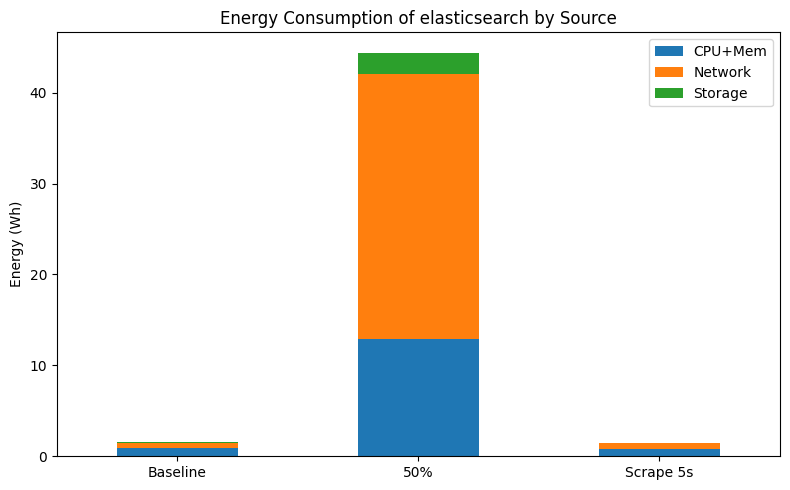

<Figure size 800x500 with 0 Axes>

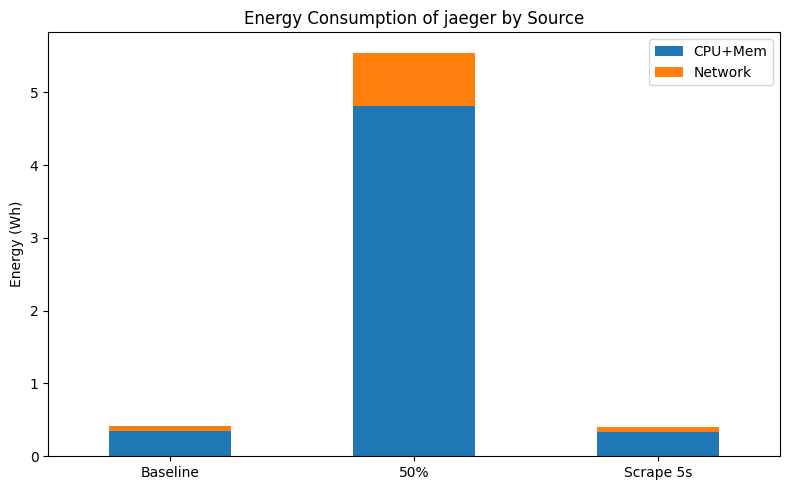

<Figure size 800x500 with 0 Axes>

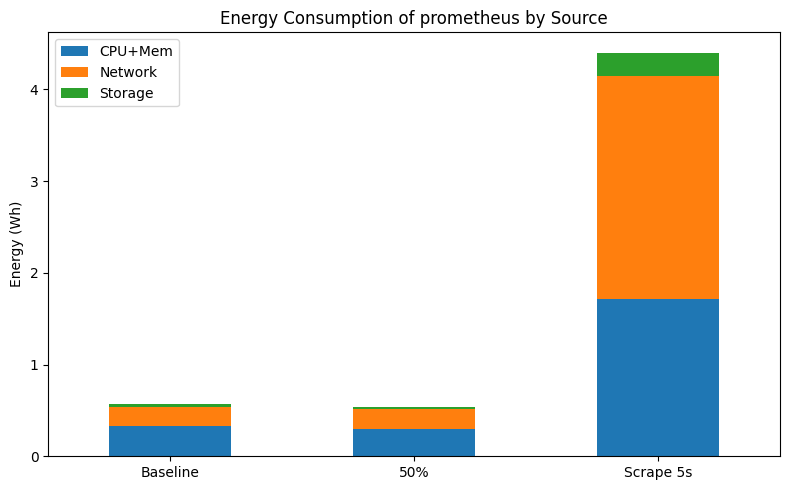

In [13]:
import matplotlib.pyplot as plt

# Define the services and experiments to visualize
services_of_interest = ["elasticsearch", "jaeger", "prometheus"]
#experiments_of_interest = ["Baseline",]
#experiments_of_interest = ["50%"]
#experiments_of_interest = ["Baseline", "Scrape 5s"]
experiments_of_interest = ["Baseline", "50%", "Scrape 5s"]



# Map to handle suffix-based matching and grouping
source_suffixes = {
    "CPU+Mem": " (CPU+Mem)",
    "Network": " (Network)",
    "Storage": " (Storage)",
}

def normalize_service_names(df):
    rename_map = {}
    for col in df.columns:
        base = col.split(" (")[0]  # separate base name from suffix
        suffix = col[len(base):]  # keep the suffix including the space and parentheses
        
        if base.startswith("prometheus"):
            new_base = "prometheus"
        elif base.startswith("jaeger"):
            new_base = "jaeger"
        elif base.startswith("opentelemetry-collector"):
            new_base = "otel-collector"
        else:
            new_base = base  # keep as-is if no match

        rename_map[col] = new_base + suffix

    # Apply renaming and group duplicates (e.g., prometheus (CPU+Mem) + prometheus-server (CPU+Mem))
    df = df.rename(columns=rename_map)
    df = df.groupby(level=0, axis=1).sum()
    return df

# Apply normalization
per_service_detailed_normalized = normalize_service_names(per_service_detailed)


# Filter the detailed per-service energy data
filtered_data = per_service_detailed_normalized.loc[experiments_of_interest]


# Create one stacked bar chart per service
for service in services_of_interest:
    plt.figure(figsize=(8, 5))
    
    data_to_plot = pd.DataFrame({
        source: filtered_data[f"{service}{suffix}"]
        for source, suffix in source_suffixes.items()
        if f"{service}{suffix}" in filtered_data.columns
    })

    data_to_plot.index = experiments_of_interest
    data_to_plot.plot(
        kind="bar",
        stacked=True,
        figsize=(8, 5),
        ylabel="Energy (Wh)",
        title=f"Energy Consumption of {service} by Source",
        legend=True
    )
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


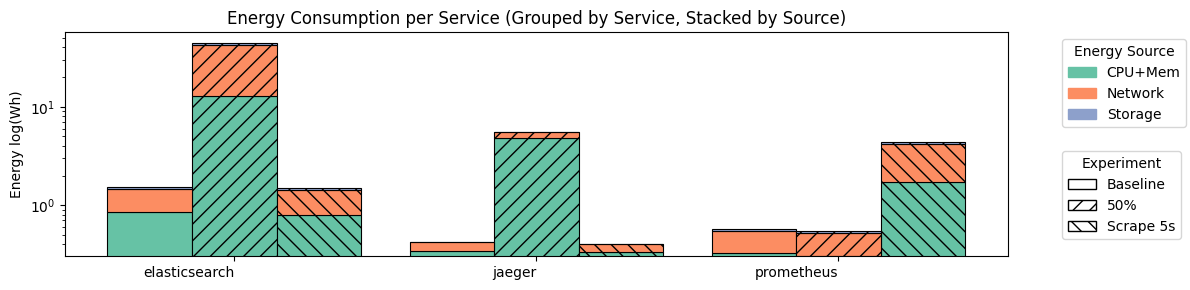

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Build long-format data
records = []
for experiment in experiments_of_interest:
    for service in services_of_interest:
        for source, suffix in source_suffixes.items():
            col = f"{service}{suffix}"
            if col in filtered_data.columns:
                energy = filtered_data.loc[experiment, col]
                records.append({
                    "Experiment": experiment,
                    "Service": service,
                    "Source": source,
                    "Energy (Wh)": energy
                })

long_df = pd.DataFrame(records)

# Pivot the long_df for stacked bars
pivot_df = long_df.pivot_table(
    index=["Service", "Experiment"],
    columns="Source",
    values="Energy (Wh)",
    aggfunc="sum"
).fillna(0).reset_index()

# Define orders
services = services_of_interest
experiments = experiments_of_interest
sources = pivot_df.columns[2:]  # energy sources

# Colors for energy sources (Set2)
source_colors = dict(zip(sources, sns.color_palette("Set2", n_colors=len(sources))))

# Bar layout
bar_width = 0.35
group_width = len(experiments) * bar_width + 0.2
x_locs = {}
for i, service in enumerate(services):
    base = i * group_width
    for j, experiment in enumerate(experiments):
        x_locs[(service, experiment)] = base + j * bar_width

# Define hatches for experiments
experiment_hatches = {
    "Baseline": "",
    "50%": "//",  # Add more patterns if more experiments
    "Scrape 5s": "\\\\",
}

# Start plotting
fig, ax = plt.subplots(figsize=(12, 3))
bar_bottoms = {key: 0 for key in x_locs}

# Stack bars with hatch per experiment
for source in sources:
    for (service, experiment), xpos in x_locs.items():
        row = pivot_df[
            (pivot_df["Service"] == service) & 
            (pivot_df["Experiment"] == experiment)
        ]
        height = row[source].values[0] if not row.empty else 0
        ax.bar(
            xpos, height,
            bottom=bar_bottoms[(service, experiment)],
            width=bar_width,
            color=source_colors[source],
            edgecolor='black',
            linewidth=0.8,
            hatch=experiment_hatches[experiment]
        )
        bar_bottoms[(service, experiment)] += height

# X-axis ticks grouped by service
service_centers = [np.mean([x_locs[(svc, exp)] for exp in experiments]) for svc in services]
ax.set_xticks(service_centers)
ax.set_xticklabels(services, ha="right")

# Source legend (colors)
source_patches = [
    mpatches.Patch(color=source_colors[src], label=src) for src in sources
]

# Experiment legend (hatches)
experiment_patches = [
    mpatches.Patch(facecolor="white", edgecolor="black", hatch=experiment_hatches[exp], label=exp)
    for exp in experiments
]

# Combined legend
legend1 = ax.legend(handles=source_patches, title="Energy Source", bbox_to_anchor=(1.05, 1), loc="upper left")
legend2 = ax.legend(handles=experiment_patches, title="Experiment", bbox_to_anchor=(1.05, 0.5), loc="upper left")
ax.add_artist(legend1)  # Keep both legends

# Labeling
ax.set_ylabel("Energy log(Wh)")
ax.set_title("Energy Consumption per Service (Grouped by Service, Stacked by Source)")
ax.set_yscale('log')  # Log scale for better visibility of differences

plt.tight_layout()
plt.show()


# Latex Tables for the Paper

In [15]:
# === CONFIGURE HERE ===
selected_experiments = ["Baseline", "Scrape 5s", "50%"]
highlight_aux_services = ["elasticsearch", "prometheus", "jaeger", "otel-collector"]


# === GLOBAL: Service name normalization function ===
def normalize_service_name(name: str) -> str:
    # Simplify common service name variants
    if name.startswith("prometheus"):
        return "prometheus"
    elif name.startswith("jaeger"):
        return "jaeger"
    elif name.startswith("opentelemetry-collector"):
        return "otel-collector"
    elif name.startswith("elasticsearch"):
        return "elasticsearch"
    else:
        return name

# === STEP 0: Normalize service names before calculating per_service_detailed ===
def normalize_service_names(df, suffix):
    rename_map = {}
    #print(f"--- Normalizing columns for suffix '{suffix}' ---")
    for col in df.columns:
        base = col
        if base.endswith(suffix):
            base = base[:-len(suffix)]
        new_base = normalize_service_name(base)
        new_col = new_base + suffix
        #print(f"  {col} → {new_col}")
        rename_map[col] = new_col
    df = df.rename(columns=rename_map)
    df = df.groupby(level=0, axis=1).sum()
    return df


# Apply normalization to each source
network_labeled = normalize_service_names(network_data_processed, " (Network)")
storage_labeled = normalize_service_names(storage_data_processed, " (Storage)")
kepler_labeled = normalize_service_names(kepler_data_joules_processed, " (CPU+Mem)")

# Combine and convert to Wh
per_service_detailed = pd.concat([kepler_labeled, network_labeled, storage_labeled], axis=1) * 1000
per_service_detailed = per_service_detailed.sort_index(axis=1)

# === STEP 1: Melt original wide table ===
df_long = per_service_detailed.reset_index().melt(id_vars='label', var_name='service_source', value_name='energy_Wh')
df_long[['service', 'source']] = df_long['service_source'].str.extract(r"^(.*?) \((.*?)\)$")

# === STEP 2: Apply correct role classification per source ===
source_mappings = {
    "CPU+Mem": kepler_mapping,
    "Storage": storage_data_mapping,
    "Network": network_data_mapping
}

def resolve_group(row):
    norm_service = normalize_service_name(row['service'])  # normalize here
    mapping = source_mappings.get(row['source'], {})
    role = mapping.get(norm_service, "Unknown")
    if role == "Primary":
        return "Primary"
    elif role == "Auxiliary":
        if norm_service in highlight_aux_services:
            return norm_service
        else:
            return "Other Auxiliary"
    else:
        return "Unknown"

df_long['group'] = df_long.apply(resolve_group, axis=1)

# === STEP 3: Filter to selected experiments only ===
df_filtered = df_long[df_long['label'].isin(selected_experiments)]

experiment_renames = {
    "Baseline": "Baseline",
    "Scrape 5s": "Monitoring High",
    "50%": "Tracing High"
}

selected_experiments = [experiment_renames[k] for k in selected_experiments]

# Reassign to df_filtered as well
df_filtered['label'] = df_filtered['label'].map(experiment_renames)


# === STEP 4: Group and pivot ===
grouped = (
    df_filtered.groupby(['source', 'label', 'group'])['energy_Wh']
    .sum()
    .reset_index()
)

# Pivot to MultiIndex columns (label=experiment, group=service role)
pivoted = grouped.pivot(index='source', columns=['label', 'group'], values='energy_Wh')

# Build desired column order
group_order = (
    ["Primary"] +
    sorted(set(highlight_aux_services) & set(df_filtered['group'])) +
    ["Other Auxiliary"]
)
ordered_columns = pd.MultiIndex.from_product(
    [selected_experiments, group_order],
    names=["label", "group"]
)

# Reindex columns (no level parameter!)
pivoted = pivoted.reindex(columns=ordered_columns)

# Final formatting
pivoted = pivoted.round(2)
pivoted = pivoted.reindex(['CPU+Mem', 'Network', 'Storage'])  # reorder rows

pivoted.loc["Total"] = pivoted.sum(axis=0)

#print(pivoted.to_markdown())

pivoted = pivoted.fillna(0)  # fill NaN with 0 for LaTeX export

source_renames = {
    "CPU+Mem": r"$E_{\mathrm{compute}}$ (Wh)",
    "Network": r"$E_{\mathrm{network}}$ (Wh)",
    "Storage": r"$E_{\mathrm{storage}}$ (Wh)"
}
pivoted.rename(index=source_renames, inplace=True)


def shorten_group_name(name):
    map_ = {
        "prometheus": "Prom.",
        "jaeger": "Jaeger",
        "otel-collector": "OTel",
        "elasticsearch": "ES",
        "Other Auxiliary": "Aux. (Other)",
        "Primary": "Primary"
    }
    return map_.get(name, name)

pivoted.columns = pd.MultiIndex.from_tuples([
    (label, shorten_group_name(group)) for label, group in pivoted.columns
])


def rotate_label(label):
    return r"\rotatebox{90}{" + label + r"}"

# This modifies the second level (group) of column labels only
pivoted.columns = pd.MultiIndex.from_tuples([
    (label, rotate_label(group)) for label, group in pivoted.columns
])


latex = pivoted.to_latex(
    escape=False,              # keep % symbols
    multicolumn=True,
    multicolumn_format='c',
    column_format = "l|" + "r" * (pivoted.shape[1]),
    float_format="%.1f",
    caption=r"Energy consumption per source and service role.",
    label=r"tab:energy_consumption_per_service_experiment_grouped"
)
print(latex)

print(pivoted.round(1).to_markdown())

\begin{table}
\caption{Energy consumption per source and service role.}
\label{tab:energy_consumption_per_service_experiment_grouped}
\begin{tabular}{l|rrrrrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{6}{c}{Baseline} & \multicolumn{6}{c}{Monitoring High} & \multicolumn{6}{c}{Tracing High} \\
 & \rotatebox{90}{Primary} & \rotatebox{90}{ES} & \rotatebox{90}{Jaeger} & \rotatebox{90}{OTel} & \rotatebox{90}{Prom.} & \rotatebox{90}{Aux. (Other)} & \rotatebox{90}{Primary} & \rotatebox{90}{ES} & \rotatebox{90}{Jaeger} & \rotatebox{90}{OTel} & \rotatebox{90}{Prom.} & \rotatebox{90}{Aux. (Other)} & \rotatebox{90}{Primary} & \rotatebox{90}{ES} & \rotatebox{90}{Jaeger} & \rotatebox{90}{OTel} & \rotatebox{90}{Prom.} & \rotatebox{90}{Aux. (Other)} \\
source &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
$E_{\mathrm{compute}}$ (Wh) & 58.4 & 0.9 & 0.3 & 4.3 & 0.3 & 5.2 & 56.8 & 0.8 & 0.3 & 4.2 & 1.7 & 5.1 & 54.5 & 12.9 & 4.8 & 4.4 & 0.3 & 4.8 \\
$E_{\mathrm{network}}$ (Wh) & 8.5 & 0.6 &

/tmp/ipykernel_388604/3447158693.py:33: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(level=0, axis=1).sum()
/tmp/ipykernel_388604/3447158693.py:33: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(level=0, axis=1).sum()
/tmp/ipykernel_388604/3447158693.py:33: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(level=0, axis=1).sum()
/tmp/ipykernel_388604/3447158693.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = df_filtered['label'].map(experiment_renames)


In [16]:
pivoted

Baseline                     \
                            \rotatebox{90}{Primary} \rotatebox{90}{ES}   
source                                                                   
$E_{\mathrm{compute}}$ (Wh)                   58.38               0.86   
$E_{\mathrm{network}}$ (Wh)                    8.47               0.60   
$E_{\mathrm{storage}}$ (Wh)                    0.05               0.07   
Total                                         66.90               1.53   

                                                                         \
                            \rotatebox{90}{Jaeger} \rotatebox{90}{OTel}   
source                                                                    
$E_{\mathrm{compute}}$ (Wh)                   0.35                 4.34   
$E_{\mathrm{network}}$ (Wh)                   0.07                10.66   
$E_{\mathrm{storage}}$ (Wh)                   0.00                 0.00   
Total                                         0.42                15.00   

                                                   \
                            \rotatebox{90}{Prom.}   
source                                              
$E_{\mathrm{compute}}$ (Wh)                  0.33   
$E_{\mathrm{network}}$ (Wh)                  0.22   
$E_{\mathrm{storage}}$ (Wh)                  0.02   
Total                                        0.57   

                                                          \
                            \rotatebox{90}{Aux. (Other)}   
source                                                     
$E_{\mathrm{compute}}$ (Wh)                         5.19   
$E_{\mathrm{network}}$ (Wh)                         0.06   
$E_{\mathrm{storage}}$ (Wh)                         4.05   
Total                                               9.30   

                                    Monitoring High                     \
                            \rotatebox{90}{Primary} \rotatebox{90}{ES}   
source                                                                   
$E_{\mathrm{compute}}$ (Wh)                   56.78               0.80   
$E_{\mathrm{network}}$ (Wh)                    8.45               0.61   
$E_{\mathrm{storage}}$ (Wh)                    0.05               0.07   
Total                                         65.28               1.48   

                                                                         \
                            \rotatebox{90}{Jaeger} \rotatebox{90}{OTel}   
source                                                                    
$E_{\mathrm{compute}}$ (Wh)                   0.33                 4.24   
$E_{\mathrm{network}}$ (Wh)                   0.07                10.67   
$E_{\mathrm{storage}}$ (Wh)                   0.00                 0.00   
Total                                         0.40                14.91   

                                                   \
                            \rotatebox{90}{Prom.}   
source                                              
$E_{\mathrm{compute}}$ (Wh)                  1.71   
$E_{\mathrm{network}}$ (Wh)                  2.44   
$E_{\mathrm{storage}}$ (Wh)                  0.26   
Total                                        4.41   

                                                          \
                            \rotatebox{90}{Aux. (Other)}   
source                                                     
$E_{\mathrm{compute}}$ (Wh)                         5.09   
$E_{\mathrm{network}}$ (Wh)                         0.06   
$E_{\mathrm{storage}}$ (Wh)                         4.03   
Total                                               9.18   

                                       Tracing High                     \
                            \rotatebox{90}{Primary} \rotatebox{90}{ES}   
source                                                                   
$E_{\mathrm{compute}}$ (Wh)                   54.45              12.90   
$E_{\mathrm{network}}$ (Wh)                    8.47              29.17 

In [17]:

latex_t = pivoted.T.to_latex(
    escape=True,              # keep % symbols
    multicolumn=True,
    multicolumn_format='c',
    column_format='lr|rrr|r',  # first col left-aligned, rest right-aligned
    float_format="%.2f",
    caption=r"Caption.",
    label=r"tab:energy_consumption_per_experiment_service_grouped"
)
print(latex_t)

\begin{table}
\caption{Caption.}
\label{tab:energy_consumption_per_experiment_service_grouped}
\begin{tabular}{lr|rrr|r}
\toprule
 & source & \$E\_\{\textbackslash mathrm\{compute\}\}\$ (Wh) & \$E\_\{\textbackslash mathrm\{network\}\}\$ (Wh) & \$E\_\{\textbackslash mathrm\{storage\}\}\$ (Wh) & Total \\
\midrule
\multirow[t]{6}{*}{Baseline} & \textbackslash rotatebox\{90\}\{Primary\} & 58.38 & 8.47 & 0.05 & 66.90 \\
 & \textbackslash rotatebox\{90\}\{ES\} & 0.86 & 0.60 & 0.07 & 1.53 \\
 & \textbackslash rotatebox\{90\}\{Jaeger\} & 0.35 & 0.07 & 0.00 & 0.42 \\
 & \textbackslash rotatebox\{90\}\{OTel\} & 4.34 & 10.66 & 0.00 & 15.00 \\
 & \textbackslash rotatebox\{90\}\{Prom.\} & 0.33 & 0.22 & 0.02 & 0.57 \\
 & \textbackslash rotatebox\{90\}\{Aux. (Other)\} & 5.19 & 0.06 & 4.05 & 9.30 \\
\cline{1-6}
\multirow[t]{6}{*}{Monitoring High} & \textbackslash rotatebox\{90\}\{Primary\} & 56.78 & 8.45 & 0.05 & 65.28 \\
 & \textbackslash rotatebox\{90\}\{ES\} & 0.80 & 0.61 & 0.07 & 1.48 \\
 & \textb

In [18]:
latex_categorized_combined_suffix = categorized_combined_suffix.round(2).copy()


# order columns 
latex_categorized_combined_suffix = latex_categorized_combined_suffix.reindex(
    columns=[
        "Primary (CPU+Mem)",
        "Primary (Network)",
        "Primary (Storage)",
        "Auxiliary (CPU+Mem)",
        "Auxiliary (Network)",
        "Auxiliary (Storage)",
        "Total",
        "Total Change (%)"
    ]
)

latex_categorized_combined_suffix.columns = pd.MultiIndex.from_tuples([
    ("Primary", "CPU+Mem"),
    ("Primary", "Network"),
    ("Primary", "Storage"),
    ("Auxiliary", "CPU+Mem"),
    ("Auxiliary", "Network"),
    ("Auxiliary", "Storage"),
    ("Total", "Absolut"),
    ("Total", "%")
])




latex_categorized_combined_suffix.index.name = ""
latex = latex_categorized_combined_suffix.to_latex(
    escape=True,              # keep % symbols
    multicolumn=True,
    multicolumn_format='c',
    column_format='l|rrr|rrr|rrr',  # first col left-aligned, rest right-aligned
    float_format="%.2f",
    caption=r"Energy consumption of the experiment runs in Wh divided into the "
            r"categories Primary and Auxiliary services.",
    label=r"tab:energy",
)
print(latex)

\begin{table}
\caption{Energy consumption of the experiment runs in Wh divided into the categories Primary and Auxiliary services.}
\label{tab:energy}
\begin{tabular}{l|rrr|rrr|rrr}
\toprule
 & \multicolumn{3}{c}{Primary} & \multicolumn{3}{c}{Auxiliary} & \multicolumn{2}{c}{Total} \\
 & CPU+Mem & Network & Storage & CPU+Mem & Network & Storage & Absolut & \% \\
 &  &  &  &  &  &  &  &  \\
\midrule
Baseline & 58.38 & 8.47 & 0.05 & 11.05 & 11.61 & 4.14 & 93.71 & 0.00 \\
Scrape 30s & 58.55 & 8.47 & 0.05 & 11.11 & 11.84 & 4.03 & 94.05 & 0.37 \\
Scrape 5s & 56.78 & 8.45 & 0.05 & 12.17 & 13.85 & 4.36 & 95.67 & 2.10 \\
5\% & 58.05 & 8.44 & 0.05 & 12.68 & 13.95 & 4.36 & 97.53 & 4.08 \\
10\% & 57.66 & 8.47 & 0.05 & 14.49 & 17.07 & 4.59 & 102.35 & 9.22 \\
50\% & 54.45 & 8.47 & 0.05 & 27.28 & 40.85 & 6.44 & 137.55 & 46.79 \\
Istio & 54.00 & 8.87 & 0.05 & 25.69 & 11.84 & 3.48 & 103.93 & 10.92 \\
\bottomrule
\end{tabular}
\end{table}



In [19]:
# STEP 0 — Set up properly with MultiIndex columns
df_abs = categorized_combined_suffix.round(2).copy()

df_abs = df_abs.reindex(columns=[
    "Primary (CPU+Mem)", "Primary (Network)", "Primary (Storage)",
    "Auxiliary (CPU+Mem)", "Auxiliary (Network)", "Auxiliary (Storage)",
    "Total", "Total Change (%)"
])

df_abs.columns = pd.MultiIndex.from_tuples([
    ("Primary",   "CPU+Mem"),
    ("Primary",   "Network"),
    ("Primary",   "Storage"),
    ("Auxiliary", "CPU+Mem"),
    ("Auxiliary", "Network"),
    ("Auxiliary", "Storage"),
    ("Total",     "Absolut"),
    ("Total",     "%")
])

df_abs.index.name = ""

# STEP 1 — Compute Δ-columns
baseline = df_abs.loc["Baseline"]  # Confirm this row exists exactly!

delta_cols = {}
for col in df_abs.columns:
    if col == ("Total", "%"):
        continue
    pct = ((df_abs[col] - baseline[col]) / baseline[col] * 100).round(1)
    delta_cols[(col[0], f"{col[1]} $\Delta$ \%")] = pct

df_delta = pd.DataFrame(delta_cols)

#print("Δ-cols created:", df_delta.columns.tolist())

# STEP 2 — Interleave columns
# Generate ordered list based on df_abs + delta_cols
ordered = []

for col in df_abs.columns:
    ordered.append(col)
    delta_col = (col[0], f"{col[1]} $\Delta$ \%")
    if delta_col in df_delta.columns:
        ordered.append(delta_col)

# Now merge
df_full = pd.concat([df_abs, df_delta], axis=1)[ordered]

#print("shape after merge:", df_full.shape)

# STEP 3 — Export to LaTeX
fmt = {c: (lambda x: f"{x:.1f}\\%") for c in df_full.columns if c[1].endswith("$\Delta$ \%") or c == ("Total", "%")}
col_fmt = "l|" + "r" * (df_full.shape[1])


columns_to_keep = [  # exact order you want in the final table
    ('Primary', 'CPU+Mem'), ('Primary', 'CPU+Mem $\Delta$ \%'),
    ('Primary', 'Network'), ('Primary', 'Network $\Delta$ \%'),
    ('Primary', 'Storage'), ('Primary', 'Storage $\Delta$ \%'),
    ('Auxiliary', 'CPU+Mem'), ('Auxiliary', 'CPU+Mem $\Delta$ \%'),
    ('Auxiliary', 'Network'), ('Auxiliary', 'Network $\Delta$ \%'),
    ('Auxiliary', 'Storage'), ('Auxiliary', 'Storage $\Delta$ \%'),
    ('Total', 'Absolut'), ('Total', 'Absolut $\Delta$ \%'),
]

df_final = df_full[columns_to_keep]

row_names = {
    "Baseline": "Baseline",
    "Scrape 30s": "Monitoring Low",
    "Scrape 5s": "Monitoring High",
    "5%": "Tracing Low",
    "10%": "Tracing Medium",
    "50%": "Tracing High",
    "Istio": "Service Mesh",
}

df_final = df_final.rename(index=row_names)

latex = df_final.to_latex(
    escape=False,
    multicolumn=True,
    multicolumn_format="c",
    column_format=col_fmt,
    float_format="%.2f",
    formatters=fmt,
    caption=(
        r"Energy consumption of experiment runs in Wh, divided into Primary and Auxiliary services. "
        r"“$\Delta$ \%” columns show the relative change to the Baseline (positive = higher consumption)."
    ),
    label=r"tab:energy_delta",
)
print(latex)


\begin{table}
\caption{Energy consumption of experiment runs in Wh, divided into Primary and Auxiliary services. “$\Delta$ \%” columns show the relative change to the Baseline (positive = higher consumption).}
\label{tab:energy_delta}
\begin{tabular}{l|rrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{6}{c}{Primary} & \multicolumn{6}{c}{Auxiliary} & \multicolumn{2}{c}{Total} \\
 & CPU+Mem & CPU+Mem $\Delta$ \% & Network & Network $\Delta$ \% & Storage & Storage $\Delta$ \% & CPU+Mem & CPU+Mem $\Delta$ \% & Network & Network $\Delta$ \% & Storage & Storage $\Delta$ \% & Absolut & Absolut $\Delta$ \% \\
 &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Baseline & 58.38 & 0.0\% & 8.47 & 0.0\% & 0.05 & 0.0\% & 11.05 & 0.0\% & 11.61 & 0.0\% & 4.14 & 0.0\% & 93.71 & 0.0\% \\
Monitoring Low & 58.55 & 0.3\% & 8.47 & 0.0\% & 0.05 & 0.0\% & 11.11 & 0.5\% & 11.84 & 2.0\% & 4.03 & -2.7\% & 94.05 & 0.4\% \\
Monitoring High & 56.78 & -2.7\% & 8.45 & -0.2\% & 0.05 & 0.0\% & 12.17 & 10.1\% & 13.85 & 19.3

In [20]:
df = combined_per_label_wh_T.round(2).copy()   # rows = services, cols = experiments
df.index.name = ""                               # keeps top-left LaTeX cell blank

redacted = 0
# loop and drop rows where total is 0.00
for index, row in df.iterrows():
    if row["Total"] < 0.1:
        df.drop(index, inplace=True)
        redacted += 1
        

# Map every experiment column to either "In-Memory", "Elasticsearch", or "" (no group)
group_map = {
    "Service Type": "",
    "Baseline":   "",
    "Low":         "Tracing",
    "Medium":        "Tracing",
    "High":        "Tracing",
    "HighM":  "Monitoring",      # rename if you prefer “0 %” etc.
    "Istio":      "Service Mesh",
}

# Ensure the DataFrame has the columns in the order we want:
ordered_cols = [
    "Service Type", "Baseline", "5%", "10%", "50%", "Scrape 5s", "Istio"
]

# merging rows that are the same but have different names (eg. prometheus and prometheus-server)
df = df.rename(index={
    "prometheus-server": "prometheus",
    "opentelemetry-collector": "otel-collector",    
    "jaeger-agent-sidecar": "jaeger",
    "jaeger-collector": "jaeger",
    "jaeger-query": "jaeger",
    "opensearch": "opensearch",
    "opensearch-checker": "opensearch",
    "elasticsearch": "elasticsearch",
})

# Sum them up to get the service totals
df = df.groupby(df.index).sum()

service_types = {
    "accounting": "Pri.",
    "ad": "Pri.",
    "cart": "Pri.",
    "checkout": "Pri.",
    "configfile": "Pri.",
    "copy-default-plugins": "Pri.",
    "currency": "Pri.",
    "email": "Pri.",
    "elasticsearch": "Aux.",
    "exporter": "Aux.",
    "flagd": "Pri.",
    "flagd-ui": "Pri.",
    "fraud-detection": "Pri.",
    "frontend": "Pri.",
    "frontend-proxy": "Pri.",
    "grafana": "Aux.",
    "image-provider": "Pri.",
    "init-config": "Pri.",
    "istio-proxy": "Aux.",
    "jaeger": "Aux.",
    "kafka": "Pri.",
    "master": "Pri.",
    "opensearch": "Aux.",
    "otel-collector": "Aux.",
    "payment": "Pri.",
    "product-catalog": "Pri.",
    "prometheus": "Aux.",
    "quote": "Pri.",
    "recommendation": "Pri.",
    "shipping": "Pri.",
    "sysctl": "Aux.",
    "valkey-cart": "Pri.",
    "wait-for-kafka": "Pri.",
    "wait-for-valkey-cart": "Pri.",
    "worker": "Pri.",
}

df["Service Type"] = df.index.map(service_types)

df = df[ordered_cols]

df = df.rename(columns={
    "5%": "Low",
    "10%": "Medium",
    "50%": "High",
    "Scrape 5s": "HighM",
})

top   = [group_map[c] for c in df.columns]
lower = df.columns                    # or any tidy-up you like
df.columns = pd.MultiIndex.from_arrays([top, lower])

latex = df.to_latex(
    escape=True,
    multicolumn=True,
    multicolumn_format='c',
    column_format='ll|r|rrr|r|r',
    float_format="%.2f",
    caption=f"Energy usage in Wh per Service. Combination of CPU, memory, network and storage energy consumption. {redacted} services where redacted that used less then 0.1 Wh",
    label="tab:energy_per_service",
)
print(latex)


\begin{table}
\caption{Energy usage in Wh per Service. Combination of CPU, memory, network and storage energy consumption. 14 services where redacted that used less then 0.1 Wh}
\label{tab:energy_per_service}
\begin{tabular}{ll|r|rrr|r|r}
\toprule
 & \multicolumn{2}{c}{} & \multicolumn{3}{c}{Tracing} & Monitoring & Service Mesh \\
label & Service Type & Baseline & Low & Medium & High & HighM & Istio \\
 &  &  &  &  &  &  &  \\
\midrule
Total & NaN & 93.71 & 97.53 & 102.35 & 137.55 & 95.67 & 103.93 \\
accounting & Pri. & 0.03 & 0.03 & 0.03 & 0.02 & 0.02 & 0.03 \\
ad & Pri. & 0.75 & 0.79 & 0.79 & 0.74 & 0.78 & 0.75 \\
cart & Pri. & 5.28 & 5.17 & 5.16 & 4.86 & 5.06 & 4.81 \\
elasticsearch & Aux. & 1.53 & 5.15 & 9.62 & 44.42 & 1.48 & 1.40 \\
exporter & Aux. & 0.01 & 0.01 & 0.02 & 0.01 & 0.01 & 0.01 \\
flagd & Pri. & 0.36 & 0.36 & 0.36 & 0.34 & 0.35 & 0.32 \\
fraud-detection & Pri. & 0.13 & 0.13 & 0.13 & 0.12 & 0.13 & 0.12 \\
frontend & Pri. & 36.69 & 36.60 & 36.31 & 34.45 & 35.79 & 34.46 \

In [21]:

# --- 2. build Δ‑to‑Baseline columns -----------------------------------------
baseline = df[("", "Baseline")]              # 2‑level column index (group, exp)

delta_cols = {}
for top, exp in df.columns:
    if exp not in ("Service Type", "Baseline"):        # skip the non‑numeric ones
        delta = ((df[(top, exp)] - baseline) / baseline * 100).round(1) 
        delta = delta.fillna(0)  # fill NaN with 0
        delta = delta.astype(str).add("\%")
        delta_cols[(top, f"{exp} $\Delta$\%")] = delta

df_delta = pd.DataFrame(delta_cols)
df_delta.fillna(0, inplace=True)  # modifies df_delta in‑place

# interleave: Baseline | Low | Low Δ | Medium | Medium Δ | …
ordered = []
for top, exp in df.columns:
    ordered.append((top, exp))
    if exp not in ("Service Type", "Baseline"):
        ordered.append((top, f"{exp} $\Delta$\%"))

df_extended = pd.concat([df, df_delta], axis=1)[ordered]

# --- 3. second LaTeX table ---------------------------------------------------
n_left  = 2                               # “label” + “Service Type”
n_right = len(df_extended.columns) - n_left + 1
col_fmt = "l" * n_left + "|" + "r" * n_right

latex_delta = df_extended.to_latex(
    escape=False,
    multicolumn=True,
    multicolumn_format="c",
    column_format=col_fmt,
    float_format="%.2f",
    caption=(
        "Energy usage in Wh per Service and relative change to the Baseline. "
        "Positive numbers mean the experiment consumed more energy than the Baseline. "
        f"{redacted} services were redacted that used less than 0.1 Wh."
    ),
    label="tab:energy_per_service_delta",
)

print(latex_delta)

\begin{table}
\caption{Energy usage in Wh per Service and relative change to the Baseline. Positive numbers mean the experiment consumed more energy than the Baseline. 14 services were redacted that used less than 0.1 Wh.}
\label{tab:energy_per_service_delta}
\begin{tabular}{ll|rrrrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{} & \multicolumn{6}{c}{Tracing} & \multicolumn{2}{c}{Monitoring} & \multicolumn{2}{c}{Service Mesh} \\
 & Service Type & Baseline & Low & Low $\Delta$\% & Medium & Medium $\Delta$\% & High & High $\Delta$\% & HighM & HighM $\Delta$\% & Istio & Istio $\Delta$\% \\
 &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Total & NaN & 93.71 & 97.53 & 4.1\% & 102.35 & 9.2\% & 137.55 & 46.8\% & 95.67 & 2.1\% & 103.93 & 10.9\% \\
accounting & Pri. & 0.03 & 0.03 & 0.0\% & 0.03 & 0.0\% & 0.02 & -33.3\% & 0.02 & -33.3\% & 0.03 & 0.0\% \\
ad & Pri. & 0.75 & 0.79 & 5.3\% & 0.79 & 5.3\% & 0.74 & -1.3\% & 0.78 & 4.0\% & 0.75 & 0.0\% \\
cart & Pri. & 5.28 & 5.17 & -2.1\% & 5.16 & -2.3\% & 

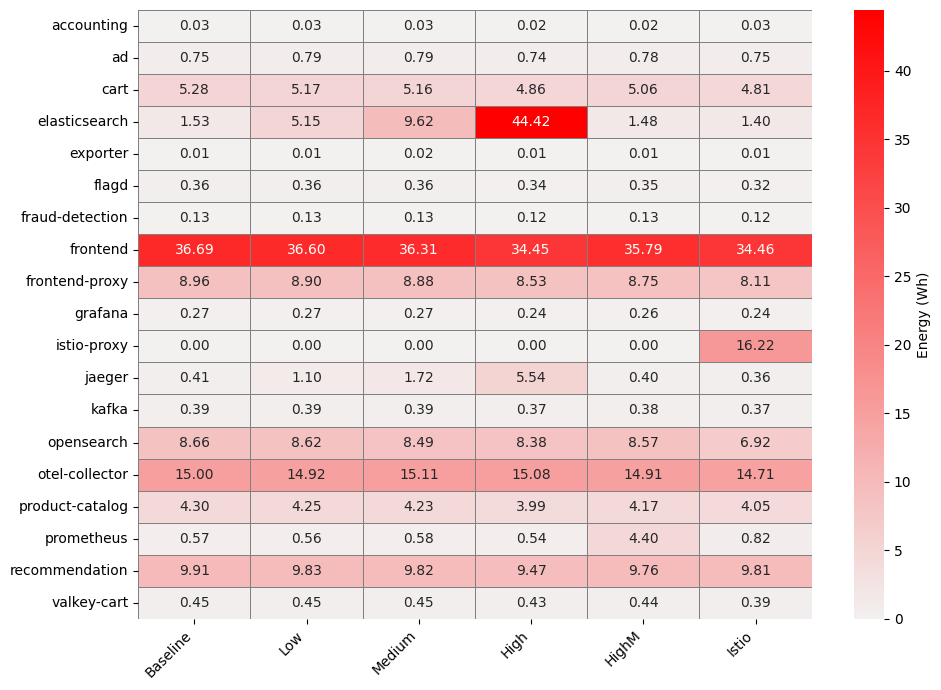

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1  Prepare the numeric matrix (drop "Total" row and "Service Type" col)
# ------------------------------------------------------------------
df_plot = df.drop(index="Total").copy()

if isinstance(df_plot.columns, pd.MultiIndex):                       # you still have a 2‑level header
    # remove the column whose *second‑level* label is "Service Type"
    df_plot = df_plot.drop(columns=[c for c in df_plot.columns
                                    if c[1] == "Service Type"])
    df_plot.columns = df_plot.columns.get_level_values(1)            # keep only the experiment names
else:
    df_plot = df_plot.drop(columns="Service Type")

df_plot = df_plot.astype(float)      # make sure everything is numeric

# ------------------------------------------------------------------
# 2  Plot the heat‑map
# ------------------------------------------------------------------
plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    df_plot,
    cmap=sns.light_palette("red", as_cmap=True),  # white → red
    annot=True, fmt=".2f",                        # write raw Wh inside the cells
    linewidths=0.4, linecolor="grey",
    cbar_kws={"label": "Energy (Wh)"}
)

ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


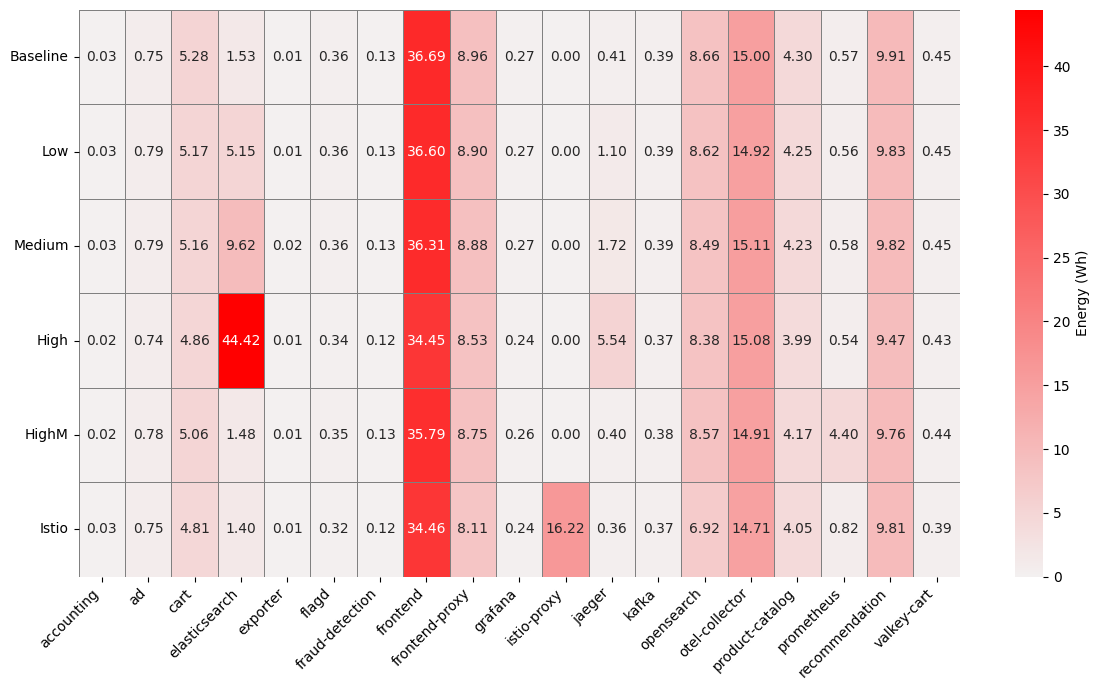

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1  Prepare the numeric matrix
# ------------------------------------------------------------------
df_plot = df.drop(index="Total").copy()

# Remove the “Service Type” text column and flatten the header
if isinstance(df_plot.columns, pd.MultiIndex):
    df_plot = df_plot.drop(
        columns=[c for c in df_plot.columns if c[1] == "Service Type"]
    )
    df_plot.columns = df_plot.columns.get_level_values(1)
else:
    df_plot = df_plot.drop(columns="Service Type")

df_plot = df_plot.astype(float)

# ------------------------------------------------------------------
# 2  Transpose so experiments are rows, services are columns
# ------------------------------------------------------------------
heat_data = df_plot.T

# ------------------------------------------------------------------
# 3  Plot the heat‑map
# ------------------------------------------------------------------
plt.figure(figsize=(12, 7))
ax = sns.heatmap(
    heat_data,
    cmap=sns.light_palette("red", as_cmap=True),  # white → red
    annot=True, fmt=".2f",
    linewidths=0.4, linecolor="grey",
    cbar_kws={"label": "Energy (Wh)"}
)

ax.set_xlabel("")               # tidy up axis titles
ax.set_ylabel("")
plt.yticks(rotation=0)          # keep experiment names horizontal
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
